In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob


from pysolar.solar import *
import datetime

In [4]:
import openeo
import rasterio.plot
import io
import tarfile

In [5]:
import xarray as xr
f='/cloud/openeo/time_series_tiny_forest_4'
loaded_data = xr.open_dataset(f, engine='netcdf4', decode_times=True)
nodata = loaded_data.attrs.get("nodata", None)
loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
loaded_data

<xarray.Dataset> Size: 3MB
Dimensions:      (t: 10, y: 52, x: 52, sun_zenith: 10)
Coordinates:
  * t            (t) datetime64[ns] 80B 2020-05-16T10:15:59.024000 ... 2020-0...
  * y            (y) float64 416B 6.917e+06 6.917e+06 ... 6.916e+06 6.916e+06
  * x            (x) float64 416B 5.589e+05 5.589e+05 ... 5.594e+05 5.594e+05
    spatial_ref  int32 4B 3006
  * sun_zenith   (sun_zenith) float64 80B 35.58 41.35 37.9 ... 41.11 37.68 36.36
Data variables: (12/16)
    b02          (t, y, x) float64 216kB 1.74e+03 1.699e+03 ... 772.0 776.0
    b03          (t, y, x) float64 216kB 1.367e+03 1.37e+03 ... 648.0 637.0
    b04          (t, y, x) float64 216kB 1.253e+03 1.25e+03 ... 387.0 389.0
    b05          (t, y, x) float64 216kB 1.475e+03 1.428e+03 ... 680.0 677.0
    b06          (t, y, x) float64 216kB 1.924e+03 1.866e+03 ... 1.339e+03
    b07          (t, y, x) float64 216kB 2.073e+03 2.065e+03 ... 1.567e+03
    ...           ...
    b11          (t, y, x) float64 216kB 1.291e+03 1.26e+03 ... 834.0 824.0
    b12          (t, y, x) float64 216kB 1.088e+03 1.122e+03 ... 397.0 398.0
    west         float64 8B 16.14
    east         float64 8B 16.15
    north        float64 8B 62.38
    south        float64 8B 62.38
Attributes:
    crs:                EPSG:3006
    nodata:             -9999
    collection:         s2_msi_l1c
    datetime_from_dim:  2024-03-26T12:47:07.333970

In [6]:
times=loaded_data['t']
variables=loaded_data.variables

In [7]:
times.data[0]

numpy.datetime64('2020-05-16T10:15:59.024000000')

In [8]:
## Bounding box coordinates ##
# OBS: need to change if image change #

In [9]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

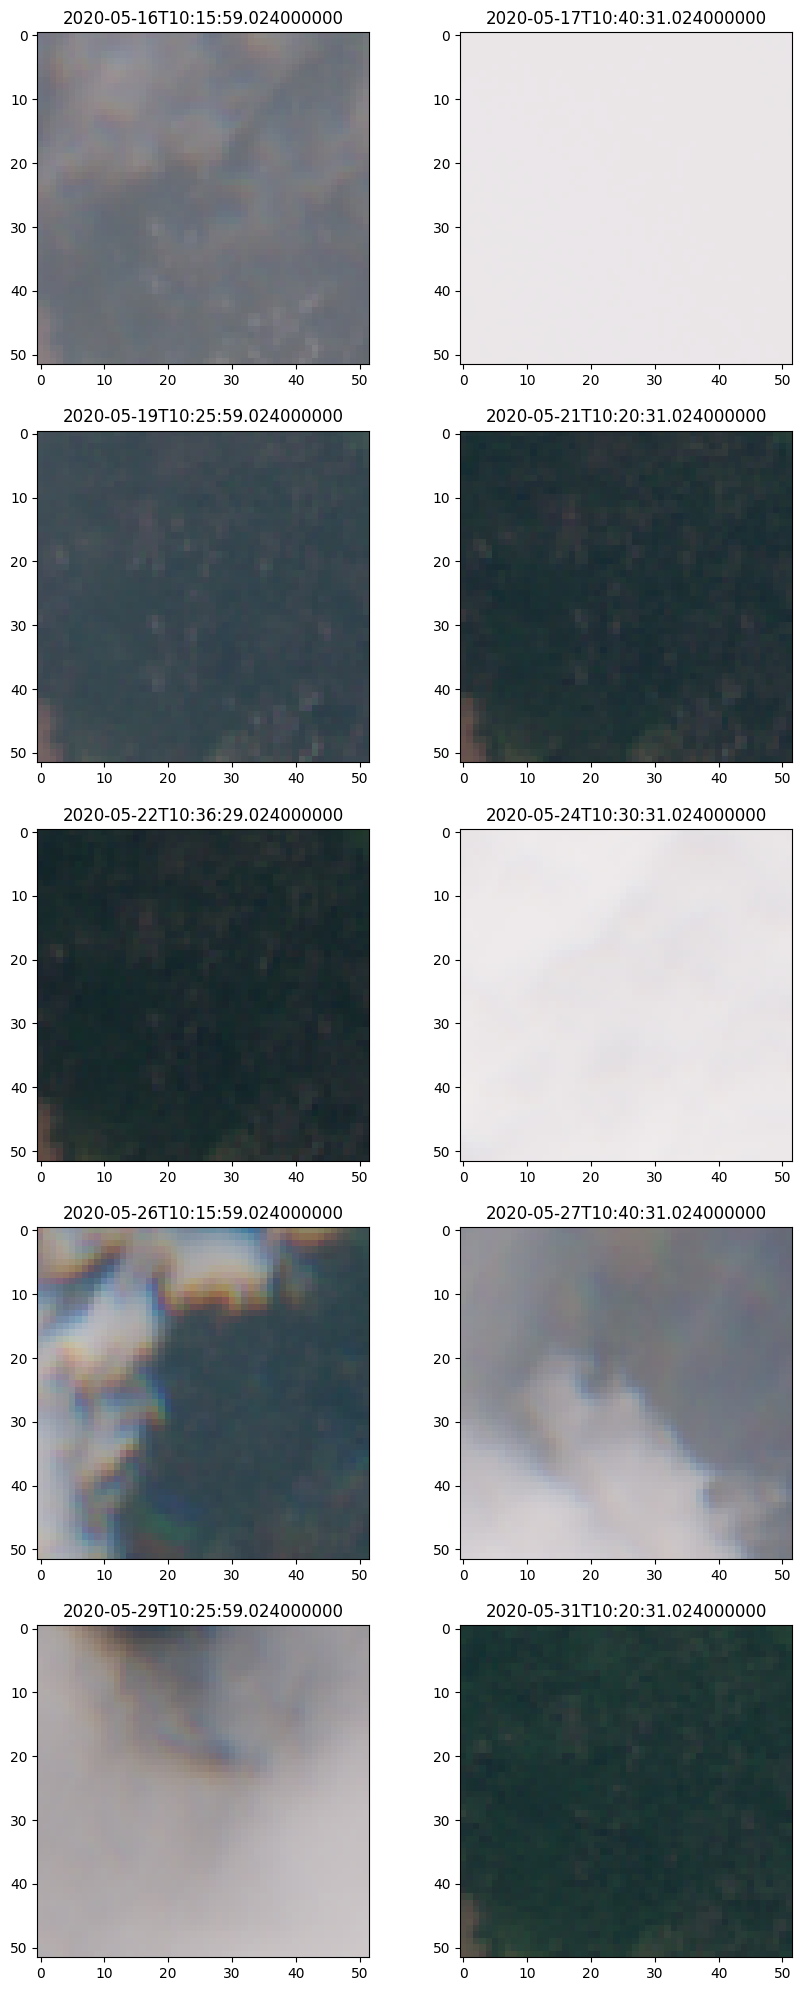

In [10]:
ncols=2
nrows=int(np.ceil(len(times)/ncols))
divide=10000
ims=[]
ims_show=[]
sun_zenith_angles=loaded_data.sun_zenith.data

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):

    ## Get bands ##
    b02=variables['b02'].data[i,:,:]/divide
    b03=variables['b03'].data[i,:,:]/divide
    b04=variables['b04'].data[i,:,:]/divide
    b05=variables['b05'].data[i,:,:]/divide
    b06=variables['b06'].data[i,:,:]/divide
    b07=variables['b07'].data[i,:,:]/divide
    b08=variables['b08'].data[i,:,:]/divide
    b8a=variables['b8a'].data[i,:,:]/divide
    b09=variables['b09'].data[i,:,:]/divide
    b10=variables['b10'].data[i,:,:]/divide
    b11=variables['b11'].data[i,:,:]/divide
    b12=variables['b12'].data[i,:,:]/divide

    ## Get "True" RGB ##
    b04T=sAdj(b04-ray['r'])
    b03T=sAdj(b03-ray['g'])
    b02T=sAdj(b02-ray['b'])

    rgbLin=satEnh(b04T,b03T,b02T)
    #avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
    for k,p in enumerate(rgbLin[0]):
        for j,q in enumerate(p):
            rgbLin[0][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[1]):
        for j,q in enumerate(p):
            rgbLin[1][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[2]):
        for j,q in enumerate(p):
            rgbLin[2][k,j]=sRGB(q)

    im_show=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
    im_show[:,:,0]=rgbLin[0]
    im_show[:,:,1]=rgbLin[1]
    im_show[:,:,2]=rgbLin[2]
    ims_show.append(im_show)

    ## Save image ##
    im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],12))
    im[:,:,0]=b02
    im[:,:,1]=b03
    im[:,:,2]=b04
    im[:,:,3]=b05
    im[:,:,4]=b06
    im[:,:,5]=b07
    im[:,:,6]=b08
    im[:,:,7]=b8a
    im[:,:,8]=b09
    im[:,:,9]=b10
    im[:,:,10]=b11
    im[:,:,11]=b12
    ims.append(im)

    ax.imshow(im_show)
    ax.set_title(times.data[i])
    

In [11]:
#pair=[5,6] # For tiny_forest_2
#pair=[1,0] # tiny_forest_3
pair=[4,0]
im_clear=ims[pair[0]]
im_cloud=ims[pair[1]]

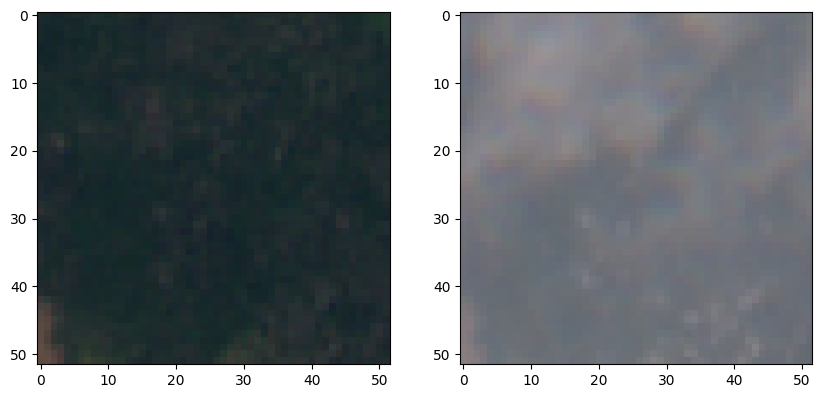

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])

In [14]:
## Load models
main_filepath='pytorch_models/Angles_as_input-Sun_Zen'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

In [15]:
## Reshape cloudy data
im_shape=np.shape(im_cloud)
im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+1)) #+1 for sun zenith angle
for i in range(im_shape[2]):
    im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

im_cloud_r[:,-1]=sun_zenith_angles[pair[1]]


In [16]:

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_cloud_r)
    else:   
        pred=pred+model.predict(im_cloud_r)
pred=pred/len(models)

In [18]:
##Reshape back
index_median=1
im_pred=np.zeros(im_shape)
im_unc=np.zeros(im_shape)
for i in range(im_shape[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape[0:2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


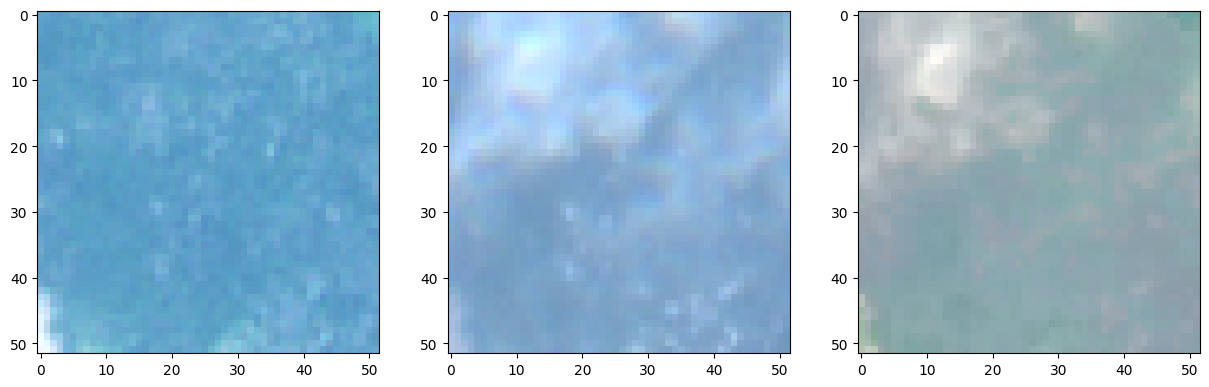

In [19]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(np.flip(im_clear[:,:,0:3],axis=2)/np.max(im_clear[:,:,0:3],axis=(0,1)))
axs[1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)/np.max(im_cloud[:,:,0:3],axis=(0,1)))
axs[2].imshow(np.flip(im_pred[:,:,0:3],axis=2)/np.max(im_pred[:,:,0:3],axis=(0,1)))

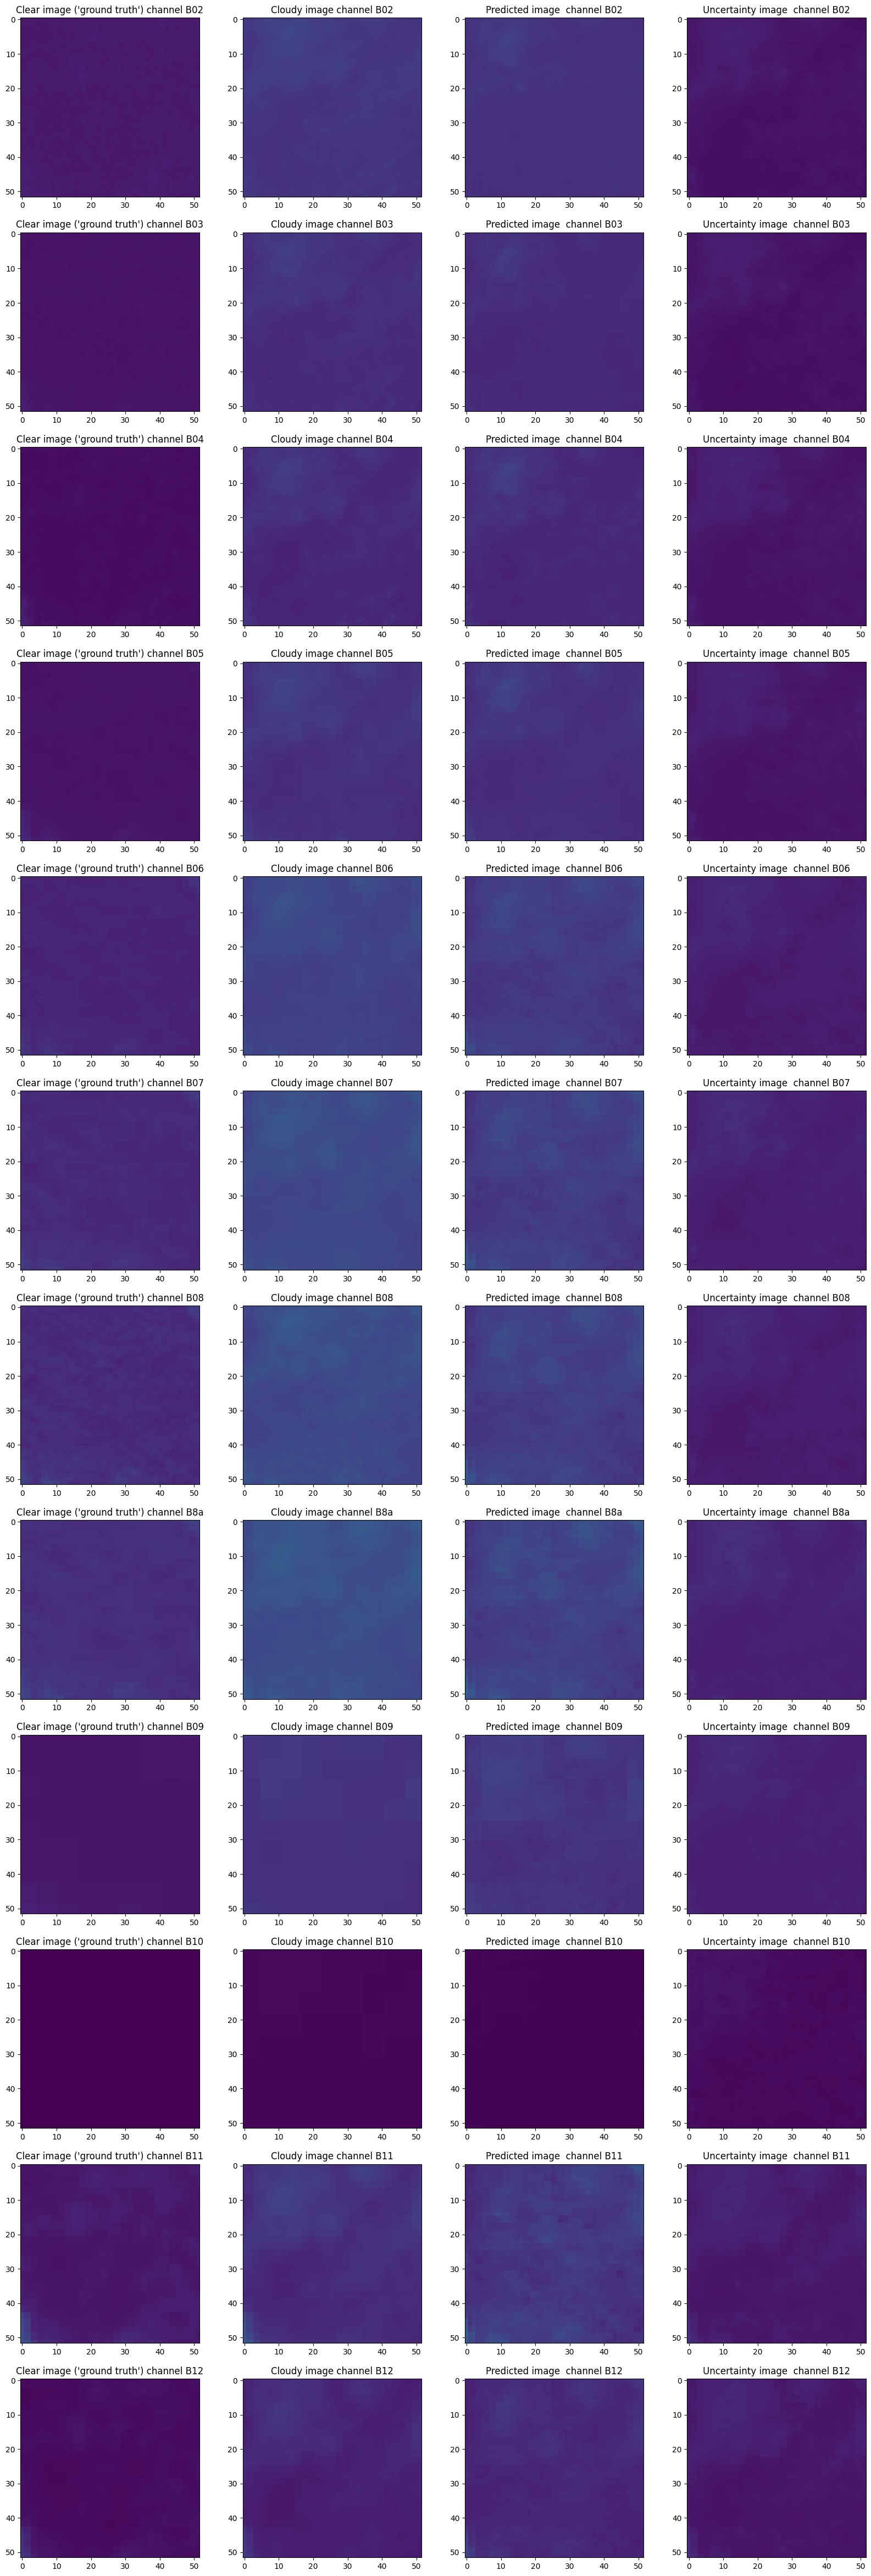

In [20]:
nchannels=12
plt.rcParams['figure.figsize'] = [20, 5*nchannels]
fig,axs=plt.subplots(ncols=4,nrows=nchannels)
for i in range(nchannels):
    axs[i,0].imshow(im_clear[:,:,i],vmin=0,vmax=1)
    axs[i,1].imshow(im_cloud[:,:,i],vmin=0,vmax=1)
    im_tmp=axs[i,2].imshow(im_pred[:,:,i],vmin=0,vmax=1)
    
    axs[i,3].imshow(im_unc[:,:,i],vmin=0,vmax=1)
    

    if i<7:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+2))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+2))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+2))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+2))
    elif i==7:
        axs[i,0].set_title("Clear image ('ground truth') channel B8a")
        axs[i,1].set_title("Cloudy image channel B8a")
        axs[i,2].set_title("Predicted image  channel B8a")
        axs[i,3].set_title("Uncertainty image  channel B8a")
    elif i==8:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+1))
    else:
        axs[i,0].set_title("Clear image ('ground truth') channel B"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B"+str(i+1))

In [21]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im_clear)-(im_cloud)),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im_clear)-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

In [22]:
for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

NMSE before correction, Band 2: 2.588010264608128
NMSE after correction, Band 2: 1.121578271538401
 
NMSE before correction, Band 3: 5.947162878257006
NMSE after correction, Band 3: 3.2780530634849545
 
NMSE before correction, Band 4: 33.865100879505036
NMSE after correction, Band 4: 31.33061178872975
 
NMSE before correction, Band 5: 8.591360140066085
NMSE after correction, Band 5: 6.230577305548718
 
NMSE before correction, Band 6: 0.859868148047471
NMSE after correction, Band 6: 0.26480751428068644
 
NMSE before correction, Band 7: 0.5776855912757833
NMSE after correction, Band 7: 0.09665956354508375
 
NMSE before correction, Band 8: 0.47962785005376096
NMSE after correction, Band 8: 0.08909022384003623
 
NMSE before correction, Band 8A: 0.4172697717210581
NMSE after correction, Band 8A: 0.05903865794762391
 
NMSE before correction, Band 9: 3.4727093856089213
NMSE after correction, Band 9: 5.6542017388023185
 
NMSE before correction, Band 10: 36809.6133749354
NMSE after correction, 

## COT model

In [198]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [199]:
model_load_paths=['cot_model/0/model_it_2000000','cot_model/1/model_it_2000000',
                  'cot_model/2/model_it_2000000','cot_model/3/model_it_2000000',
                  'cot_model/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

In [200]:
means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

In [201]:
inputs = (im_cloud_r - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)
#image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=preds.cpu().data.numpy() #unnormalise

## Reshape back
im_pred_cot=np.reshape(image_pred_cot,im_shape[0:2])

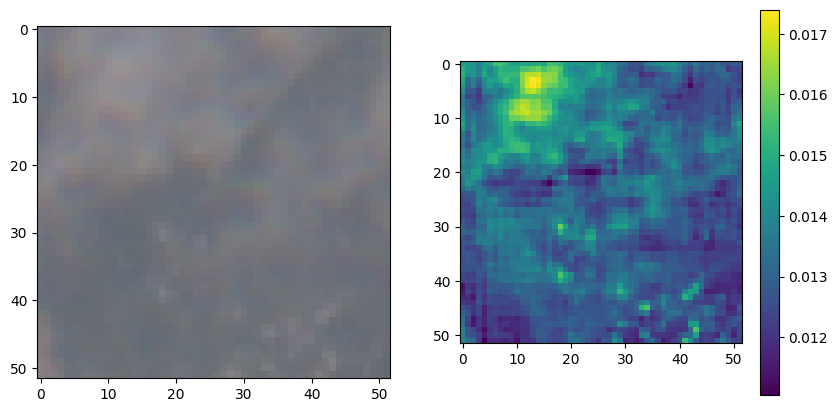

In [202]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs =plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[pair[1]])
im_cot=axs[1].imshow(im_pred_cot)
fig.colorbar(im_cot,ax=axs[1])